### FRAUD DETECTION IN FINANTIAL TRANSACTIONS USING ANOMALY DETECTION WITH AUTOENCODER NETWORKS AND RANDOM FOREST MODEL BY CAIO QUINAMO

#### IMPORT NECESSARY LIBRARIES

In [3]:
import pandas as pd
import numpy as np

from IPython.display import HTML, display
from scipy import stats, spatial

import matplotlib.pyplot as plt
from matplotlib import gridspec
import seaborn as sns

from sklearn import manifold
from sklearn import decomposition
from sklearn import preprocessing
from sklearn import model_selection
from sklearn import pipeline
from sklearn import feature_selection
from sklearn import ensemble
from sklearn import metrics

import tensorflow as tf
from tensorflow import keras

import warnings
import random

np.random.seed(4)
sns.set_style('dark')
warnings.simplefilter(action='ignore', category=FutureWarning)

#### ABOUT DATA

In [5]:
rawdata = pd.read_csv('Dataset NDSPP.2025.0001.01.1.csv')
data = rawdata.copy(deep=False)
data0, data1 = data[data['Class'] == 0], data[data['Class'] == 1]

In [6]:
# General Info
display(HTML("<h4 style=font-weight:bold; '>Data 0. Duplicated Records</h4>"), data0.duplicated().sum())

if data0.duplicated().sum() == 0:
    display(HTML("<h5 style=font-weight:bold; '>No duplicated records found</h5>"))
else:
    data0 = data0.drop_duplicates().reset_index(drop=True)
    display(HTML("<h5 style=font-weight:bold; '>Duplicated records removed successfully</h5>"))
display(HTML("<h4 style=font-weight:bold; '>Data 1. Duplicated Records</h4>"), data1.duplicated().sum())
display(HTML("<h5 style=font-weight:bold; '>Duplicated records will not be removed</h5>"))

1062

19

#### AUTOENCODER NETWORK MIN MAX

In [8]:
pps = preprocessing.MinMaxScaler()
data0, data1 = data0.drop('Time', axis=1), data1.drop('Time', axis=1)

X0, y0 = data0.drop(columns='Class').values, data0['Class'].values ## Non Fraud
X0train, X0test, y0train, y0test =     model_selection.train_test_split(X0, y0, test_size=0.30, random_state=4)
X0test, X0val, y0test, y0val = model_selection.train_test_split(X0test, y0test, test_size=0.30, random_state=4)
X0train, X0test = pps.fit_transform(X0train), pps.transform(X0test)

X1, y1 = data1.drop(columns='Class').values, data1['Class'].values ## True Fraud
X1test, X1val, y1test, y1val = model_selection.train_test_split(X1, y1, test_size=0.30, random_state=4)
X1test = pps.transform(X1test)

In [9]:
np.random.seed(4), random.seed(4), tf.random.set_seed(4)

inputlayer = keras.layers.Input(shape=(X0train.shape[1],))

encoded = keras.layers.Dense(128, activation='tanh')(inputlayer)
encoded = keras.layers.Dropout(0.3)(encoded)
encoded = keras.layers.Dense(64, activation='relu')(encoded)
encoded = keras.layers.Dropout(0.3)(encoded)

decoded = keras.layers.Dense(128, activation='tanh')(encoded)
decoded = keras.layers.Dense(64, activation='tanh')(decoded)

outputlayer = keras.layers.Dense(units=X0train.shape[1], activation='relu')(decoded)

autoencoder = keras.models.Model(inputlayer, outputlayer)

autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.fit(X0train, X0train, epochs=25, batch_size=256, shuffle=True, validation_split=0.3, verbose=1)

Epoch 1/25
543/543 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0242 - val_loss: 0.0015
Epoch 2/25
543/543 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0014 - val_loss: 4.7517e-04
Epoch 3/25
543/543 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 7.5057e-04 - val_loss: 3.2008e-04
Epoch 4/25
543/543 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 6.2269e-04 - val_loss: 2.4741e-04
Epoch 5/25
543/543 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 5.4798e-04 - val_loss: 2.1840e-04
Epoch 6/25
543/543 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 5.1124e-04 - val_loss: 1.9050e-04
Epoch 7/25
543/543 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4.8849e-04 - val_loss: 1.7646e-04
Epoch 8/25
543/543 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4.7188e-04 - val_loss: 1.8768e-04
Epoch 9/25
543/543 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4.6307e-04 - val_loss: 1.8100e-04
Epoch 10/25
543/543 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4.5472e-04 - val_loss: 1.7224e-04
Epoch 11/25
543/543 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4.4721e-04

#### AUTOENCODER RECONSTRUCTION & FEATURE ENGINEERING

In [11]:
Xreconstructed = autoencoder.predict(np.concatenate([X0test, X1test]))
Rerror = np.mean(np.square(np.concatenate([X0test, X1test]) - Xreconstructed), axis=1).reshape(-1,1)

Xmodel = np.concatenate([Xreconstructed, Rerror], axis=1)
ymodel = np.concatenate([y0test, y1test])

1870/1870 ━━━━━━━━━━━━━━━━━━━━ 1s 493us/step


In [12]:
columns = list(data.columns.drop(['Time', 'Class']))
columns.append('R. Error')
datamodel = pd.DataFrame(Xmodel, columns=columns)
datamodel['Class'] = ymodel
datamodel0, datamodel1 = datamodel[datamodel['Class'] == 0], datamodel[datamodel['Class'] == 1]

##### 1. 2-D DATA VISUALISATION (AFTER PREPROCESSING AND AUTOENCODER RECONSTRUCTION)

In [14]:
tsne = manifold.TSNE(n_components=2, random_state=4, n_jobs=-1)

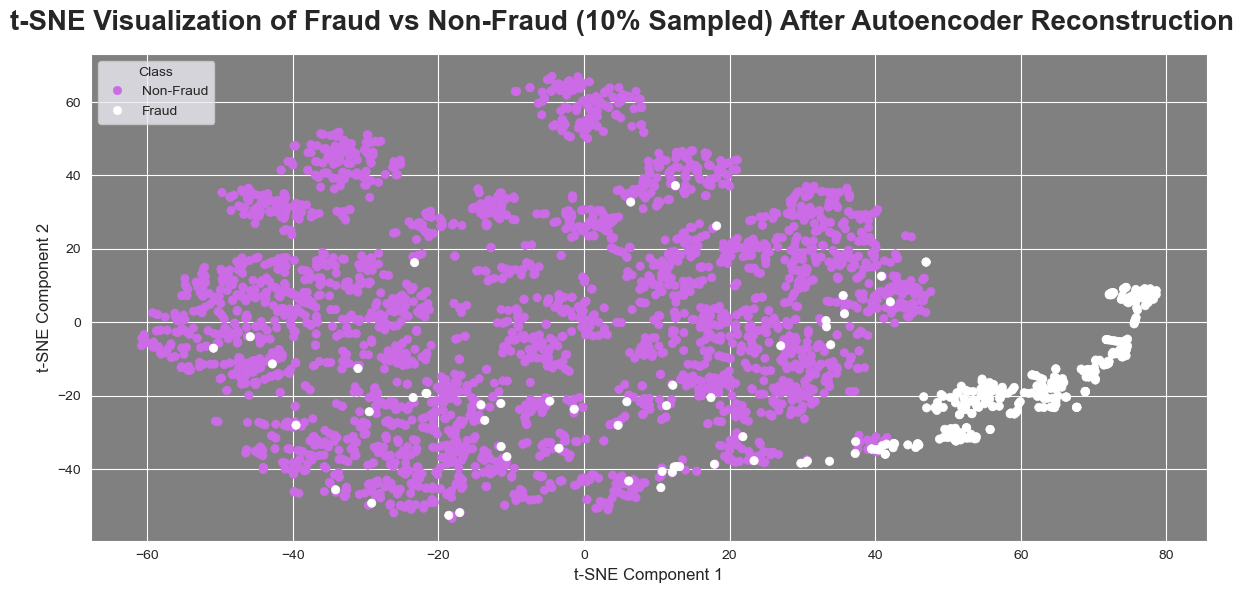

In [15]:
np.random.seed(4)

fig, ax = plt.subplots(figsize=(12, 6))

plotdata0 = datamodel0.iloc[np.random.choice(datamodel0.shape[0], int(len(datamodel0) * 0.05), replace=False)]
plotdata = pd.concat([plotdata0, datamodel1], axis=0).reset_index(drop=True)
Xsampled, ysampled = plotdata.drop(['Class'], axis=1).values, plotdata["Class"].values

Xtsne = tsne.fit_transform(Xsampled)
hue = pd.Series(ysampled).replace({0:'Non-Fraud', 1:'Fraud'})

sns.scatterplot(x=Xtsne[:,0], y=Xtsne[:,1], hue=hue, palette=['#CB6CE6', 'white'], edgecolor=None)
plt.grid(), ax.set_facecolor('grey'), plt.legend(title='Class', loc='upper left')
plt.xlabel('t-SNE Component 1', fontsize=12), plt.ylabel('t-SNE Component 2', fontsize=12)
plt.suptitle('t-SNE Visualization of Fraud vs Non-Fraud (10% Sampled) After Autoencoder Reconstruction',
             fontsize=20, fontweight='bold'), plt.tight_layout();

#### RANDOM FOREST MODEL

In [17]:
rfc = ensemble.RandomForestClassifier(n_jobs=-1, random_state=4)

In [18]:
cv = model_selection.StratifiedKFold(n_splits=10, shuffle=True, random_state=4)
yprob_cv = model_selection.cross_val_predict(rfc, Xmodel, ymodel, cv=cv, method='predict_proba', n_jobs=-1)[:, 1]

thresholds = np.linspace(0.1, 0.9, 80)
meanscores = []

for thresh in thresholds:
    ypred_thresh = (yprob_cv >= thresh).astype(int)
    score = metrics.average_precision_score(ymodel, ypred_thresh)
    meanscores.append(score)

bestthresh = thresholds[np.argmax(meanscores)]
print(f"Best Threshold = {bestthresh:.2f} with Average Precision = {max(meanscores):.4f}")

Best Threshold = 0.28 with Average Precision = 0.7809


In [19]:
display(rfc.fit(Xmodel, ymodel))

RandomForestClassifier(n_jobs=-1, random_state=4)

In [20]:
# DATA PIPELINE PROCESS
Xfinal, yfinal = np.concatenate([X0val, X1val]), np.concatenate([y0val, y1val]) ## CONCATENATE ONLY IN THIS CASE
Xfinal = pps.transform(Xfinal) ## 1. MIN-MAX SCALER TRANSFORMATION
Xrec = autoencoder.predict(Xfinal) ## 2. AUTOENCODER NETWORK RECONSTRUCTION
Rerror = np.mean(np.square(Xfinal - Xrec), axis=1).reshape(-1, 1) ## 3. CALCULATE RECONSTRUCTION ERROR
Xfinal = np.concatenate([Xrec, Rerror], axis=1) ## 4. FINAL DATA (AUTOENCODER OUTPUT + R. ERROR)

802/802 ━━━━━━━━━━━━━━━━━━━━ 0s 523us/step


In [21]:
yprob = rfc.predict_proba(Xfinal)[:, 1]
ypred = (yprob >= bestthresh).astype(int)
clsrprt = metrics.classification_report(yfinal, ypred, output_dict=True)
report = pd.DataFrame(clsrprt).transpose()
report = report.style.set_table_attributes('style="margin-left: auto; margin-right: auto;"')
display(HTML("<h3 style='font-weight:bold;' >Random Forest Classifier Metrics (Trained and Tested with Autoencoder Reconstructed Data)</h3>"))
display(report)

,precision,recall,f1-score,support
0,0.998981,0.999529,0.999255,25493.000000
1,0.910448,0.824324,0.865248,148.000000
accuracy,0.998518,0.998518,0.998518,0.998518
macro avg,0.954714,0.911927,0.932252,25641.000000
weighted avg,0.998470,0.998518,0.998481,25641.000000


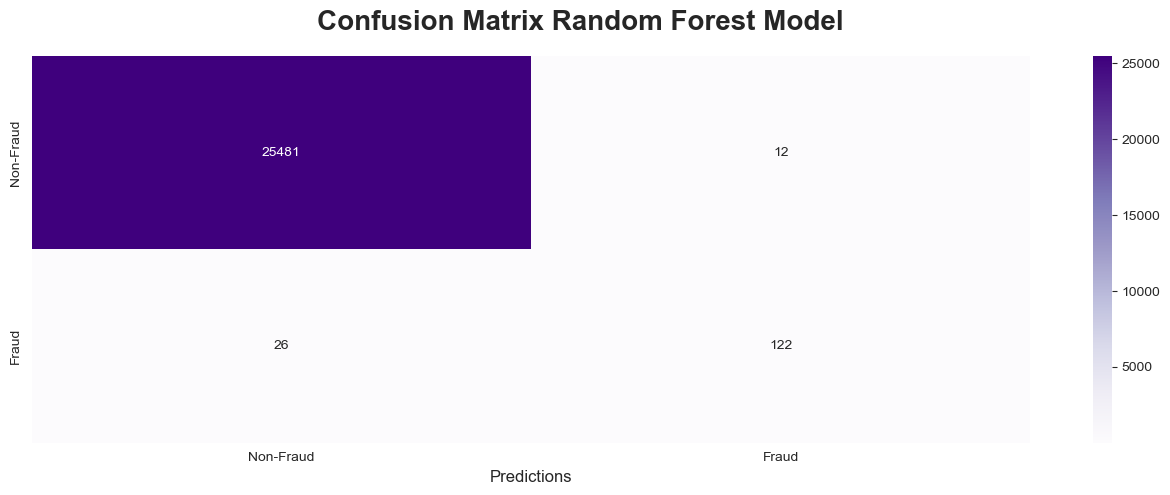

In [22]:
fig, ax = plt.subplots(figsize=(13, 5))
cm = metrics.confusion_matrix(yfinal, ypred)

sns.heatmap(cm, annot=True, fmt='d', cmap='Purples', xticklabels=['Non-Fraud', 'Fraud'], yticklabels=['Non-Fraud', 'Fraud'])
plt.xlabel('Predictions', fontsize=12), plt.ylabel(None)
plt.suptitle('Confusion Matrix Random Forest Model', fontsize=20, fontweight='bold', x=0.45), plt.tight_layout();

AttributeError: 'RandomForestClassifier' object has no attribute 'named_steps'

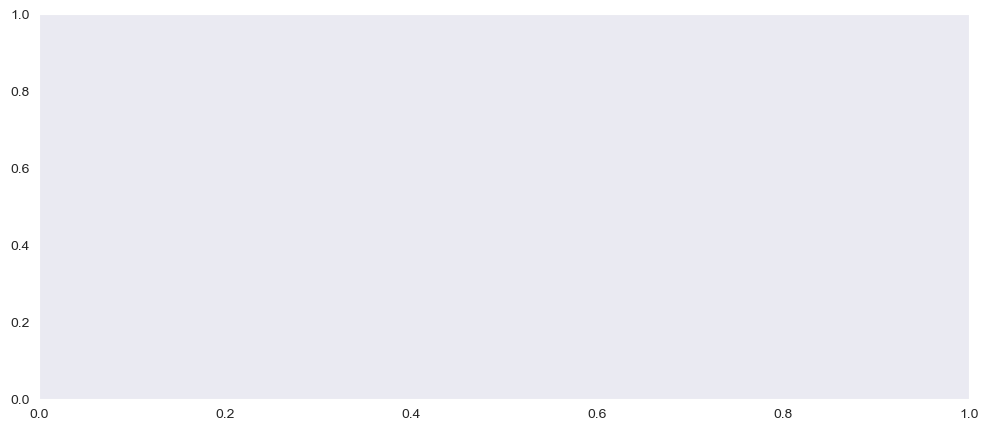

In [23]:
fig, ax = plt.subplots(figsize=(12, 5))
index = datamodel.drop(columns='Class').columns[rfc.named_steps['kbest'].get_support()]
importances = pd.DataFrame(data=rfc.named_steps['clf'].feature_importances_, columns=['Feature'], index=index)
importances = importances.reset_index().sort_values(by='Feature', ascending=False).reset_index(drop=True)

sns.barplot(data=importances, x='index', y='Feature', palette='light:m_r', width=0.7)
plt.xlabel('Feature', fontsize=12), plt.ylabel('Importance', fontsize=12)
plt.suptitle('Feature Importances in Random Forest Classifier', fontsize=20, fontweight='bold')
plt.xticks(rotation=-30), plt.grid(), ax.set_facecolor('grey'), plt.tight_layout();

In [ ]:
fig, ax = plt.subplots(figsize=(12, 5))
precision, recall, _ = metrics.precision_recall_curve(yfinal, yprob)
avgps = metrics.average_precision_score(yfinal, yprob)

ax.plot(recall, precision, color='#CB6CE6', linewidth=4)
str_text = f'Precision-Recall Score\nAverage = {avgps:.3f}'
ax.text(0, 0.05, str_text, fontsize=14, bbox=dict(facecolor='white', alpha=0.7, edgecolor='w', boxstyle='round,pad=1'))
ax.set_xlabel('Recall', fontsize=12), ax.set_ylabel('Precision', fontsize=12)
ax.set_title('Precision-Recall Curve Random Forest Model', fontsize=20, fontweight='bold')
ax.set_facecolor('grey'), plt.grid(True), plt.tight_layout();

In [ ]:
fig, ax = plt.subplots(figsize=(12, 5))

fpr, tpr, _ = metrics.roc_curve(yfinal, yprob)
roc_auc = metrics.auc(fpr, tpr)

plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.3f})', color='#CB6CE6', linewidth=4)
sns.lineplot(x=[0, 1], y=[0, 1], label='Random Classifier', color='white', linestyle='--')
plt.xlabel('False Positive Rate (FPR)', fontsize=12), plt.ylabel('True Posivitive Rate (TPR)', fontsize=12)
plt.suptitle('Receiver Operating Characteristic (ROC) Curve', fontsize=20, fontweight='bold')
plt.legend(loc='lower right'), ax.set_facecolor('grey'), plt.grid(), plt.tight_layout();

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(12, 12))
Xftsne = tsne.fit_transform(Xfinal)

huefinal = pd.Series(yfinal).replace({0:'Non-Fraud', 1:'Fraud'})
sns.scatterplot(x=Xftsne[:, 0], y=Xftsne[:, 1], hue=huefinal, palette=['#CB6CE6', 'white'], edgecolor=None, ax=axs[0])
axs[0].set_title('t-SNE Projection - True Labels', fontsize=16, fontweight='bold')
axs[0].set_xlabel('t-SNE Component 1'), axs[0].set_ylabel('t-SNE Component 2')
axs[0].set_facecolor('grey'), axs[0].grid(), axs[0].legend(title='True Class')

huepred = pd.Series(ypred).replace({0:'Non-Fraud', 1:'Fraud'})
sns.scatterplot(x=Xftsne[:, 0], y=Xftsne[:, 1], hue=huepred, palette=['#CB6CE6', 'white'], edgecolor=None, ax=axs[1])
axs[1].set_title('t-SNE Projection - Predicted Labels', fontsize=16, fontweight='bold')
axs[1].set_xlabel('t-SNE Component 1'), axs[1].set_ylabel('t-SNE Component 2')
axs[1].set_facecolor('grey'), axs[1].grid(), axs[1].legend(title='Predicted Class')

fig.suptitle('Comparison of True vs Predicted Labels on t-SNE Projection of Test Data', fontsize=20, fontweight='bold'), plt.tight_layout();